# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
# Imports here
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms
import torchvision.models as models

import helper
import time

from PIL import Image
import numpy as np

import os


#use the following when I can figure out how to use it. 

#from workspace_utils import active_session

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [2]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:
# TODO: Define your transforms for the training, validation, and testing sets

#data_transforms = transforms.Compose([transforms.Resize(255), transforms.CenterCrop(224), transforms.ToTensor()])

train_transforms = transforms.Compose([transforms.RandomRotation(30), 
                                       transforms.RandomResizedCrop(224), 
                                       transforms.RandomHorizontalFlip(), 
                                       transforms.ToTensor(), 
                                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

val_transforms = transforms.Compose([transforms.Resize(256), 
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256), 
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])


# TODO: Load the datasets with ImageFolder

#image_datasets = datasets.ImageFolder(data_dir, transform= data_transforms)

train_data = datasets.ImageFolder(train_dir, transform= train_transforms)
val_data = datasets.ImageFolder(valid_dir, transform= val_transforms)
test_data = datasets.ImageFolder(test_dir, transform= test_transforms)

# TODO: Using the image datasets and the trainforms, define the dataloaders

#dataloaders = torch.utils.data.DataLoader(image_datasets, batch_size=32, shuffle=True)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
validloader = torch.utils.data.DataLoader(val_data, batch_size=32)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32)


### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [4]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

**Note for Workspace users:** If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [5]:
# TODO: Build and train your network
#Load a pre-trained network (If you need a starting point, the VGG networks work great and are straightforward to use)

model_densenet121 = models.densenet121(pretrained = True)

/opt/conda/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.torch/models/densenet121-a639ec97.pth
100%|██████████| 32342954/32342954 [00:00<00:00, 46931589.33it/s]


In [6]:
# model_densenet121

In [6]:
# EDIT: Freeze parameters so we don't backpropagate through them
for param in model_densenet121.parameters():
    param.requires_grad = False

In [7]:
# Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout


# Hyperparameters for network

input_size = 1024 
output_size = 102 # This is the number of flower categories
hidden_layers = [16384]
drop_p = 0.2

class Network(nn.Module):
    '''
    Using the example from Part 5, Inference and Validation:
    
    Builds a feedforward network with arbitrary hidden layers.
    
    Arguments:
    
    input_size: integer type, size of the input
    output_size: integer type, size of the output layer
    hidden_layers: List type integers, the sizes of the hidden layers
    drop_p: float type between 0.0 and 1.0, dropout probability
    
    '''
    def __init__(self, input_size, output_size, hidden_layers, drop_p = 0.5):
        
        super().__init__()
        #Add the fist layer, and input to the first hidden layer
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_layers[0])])
    
        # Add arbitrary additional hidden layers:
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        self.hidden_layers.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])
    
        self.output = nn.Linear(hidden_layers[-1], output_size)
    
        self.dropout = nn.Dropout(p = drop_p)
    
    def forward(self, x):
        # Forward pass through the network, returns the output logits
        
        # Forward through each layer in hidden_layers, with ReLU activation and dropout
        
        for linear in self.hidden_layers:
            x = F.relu(linear(x))
            x = self.dropout(x)
            
        x = self.output(x)
        
        return F.log_softmax(x, dim = 1)
    

In [8]:
# Create the network, define the criterion and the optimizer
print('Hyperparameters:')
print('input_size:  ', input_size, '  output_size:  ', output_size)
print('hidden layers:  ', hidden_layers)
print('drop probability  ', drop_p)

model = Network(input_size, output_size, hidden_layers, drop_p )

model


Hyperparameters:
input_size:   1024   output_size:   102
hidden layers:   [16384]
drop probability   0.2


Network(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=1024, out_features=16384, bias=True)
  )
  (output): Linear(in_features=16384, out_features=102, bias=True)
  (dropout): Dropout(p=0.2)
)

In [9]:
#Edit: Assign the classifier attribute of model_densenet
model_densenet121.classifier = model


In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
input = model.to(device)
print('device ', device)
criterion = nn.NLLLoss()

learn_rate = 0.007
# optimizer = optim.Adam(model.parameters(), lr = 0.001)
'''Edit: 
We are interested in transfer learning by only training the final classifier,
So we need to optimize only the classifier'''

#optimizer = optim.Adam(model.classifier.parameters(), lr = 0.001)
optimizer = optim.Adam(model_densenet121.classifier.parameters(), lr = learn_rate)

print('learning rate  ', learn_rate)

params_dict = {'input_size' : input_size, 'output_size' : output_size, 
               'hidden_layers' : hidden_layers, 'drop probability' : drop_p, 
               'learning_rate' : learn_rate}

print(params_dict)
#print("len testloader \n", len(testloader), shape.testloader)

device  cuda:0
learning rate   0.007
{'input_size': 1024, 'output_size': 102, 'hidden_layers': [16384], 'drop probability': 0.2, 'learning_rate': 0.007}


## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [13]:
# TODO: Do validation on the test set
def validation(model, validloader, criterion):
    test_loss = 0
    accuracy = 0
    for images, labels in validloader:
        #turn this on later when running GPU
        images, labels = images.to(device), labels.to(device)
        

        #output = model.forward(images)
        #Edit: use the densenet model
        ##output = model_densenet121.forward(images)
        ##Edit again: use model
        output = model.forward(images)
        
        test_loss += criterion(output, labels).item()
        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    return test_loss, accuracy


In [14]:
# Keep session active
# DOESNT WORK!!!!!!!!!!!!!!
#with active_session:
# Run validation

###################
model_densenet121.to('cuda')

epochs = 5
steps = 0
running_loss = 0
print_every = 51 #40 
count = 0

# update parameters dictionary with epochs: 
params_dict['num_epochs'] = epochs

print(params_dict)

for e in range(epochs):
    if count > 0:
        print('epoch=', e, 'count= ', count-1)
    count = 0
    ## Edit 1: change model.train() to model_densenet121.train()
    # model.train()
    model_densenet121.train()
    for images, labels in trainloader:
        
        images, labels = images.to(device), labels.to(device)
        
        steps += 1
        count += 1
        #print('steps = ', steps)
       

        optimizer.zero_grad()

        #output = model.forward(images)
        
        #Edit: use the densenet model
        output = model_densenet121.forward(images)

        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        #print('made it past optimizer.step')
        
        if steps % print_every == 0:
            start = time.time()
            # Put Model in eval mode for inference
            ## Edit 2: change model.eval() to model_densenet121.eval()
            #model.eval()
            model_densenet121.eval()
            
            # Turn off gradients for validation (saves memory and computations) 
            with torch.no_grad():
                #test_loss, accuracy = validation(model, testloader, criterion)
                test_loss, accuracy = validation(model_densenet121, testloader, criterion)
            print("Epoch: {}/{}..".format(e+1, epochs),
                "Training Loss: {:.3f}..".format(running_loss/print_every),
                "Test Loss: {:.3f}..".format(test_loss/len(testloader)),
                "Test Accuracy: {:.3f}".format(accuracy/len(testloader)),
                "Steps = ", steps)
            
            running_loss = 0
            
            #turn training back on
            ## Edit 3: change model.train() to model_densenet.train()
            #model.train()
            model_densenet121.train()
            
            print(f"Device = {device}; Time per {print_every} steps: {(time.time() - start)/3:.3f} seconds")
            
        

{'input_size': 1024, 'output_size': 102, 'hidden_layers': [16384], 'drop probability': 0.2, 'learning_rate': 0.007, 'num_epochs': 5}
Epoch: 1/5.. Training Loss: 9.827.. Test Loss: 2.062.. Test Accuracy: 0.479 Steps =  51
Device = cuda:0; Time per 51 steps: 5.040 seconds
Epoch: 1/5.. Training Loss: 2.045.. Test Loss: 1.222.. Test Accuracy: 0.642 Steps =  102
Device = cuda:0; Time per 51 steps: 4.463 seconds
epoch= 1 count=  102
Epoch: 2/5.. Training Loss: 1.581.. Test Loss: 0.968.. Test Accuracy: 0.714 Steps =  153
Device = cuda:0; Time per 51 steps: 4.468 seconds
Epoch: 2/5.. Training Loss: 1.435.. Test Loss: 0.778.. Test Accuracy: 0.761 Steps =  204
Device = cuda:0; Time per 51 steps: 4.433 seconds
epoch= 2 count=  102
Epoch: 3/5.. Training Loss: 1.257.. Test Loss: 0.733.. Test Accuracy: 0.791 Steps =  255
Device = cuda:0; Time per 51 steps: 4.450 seconds
Epoch: 3/5.. Training Loss: 1.290.. Test Loss: 0.721.. Test Accuracy: 0.801 Steps =  306
Device = cuda:0; Time per 51 steps: 4.439 

## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [23]:
# TODO: Save the checkpoint 

#model_densenet121.class_to_idx = image_datasets['train'].class_to_idx
model_densenet121.class_to_idx = train_data.class_to_idx

checkpoint= {'input_size': input_size, 
             'output_size' : output_size,
            'hidden_layers' : hidden_layers,
             'num_epochs' : epochs,
             'class_to_idx' : model_densenet121.class_to_idx,
            'state_dict' : model_densenet121.state_dict()}
torch.save(checkpoint, 'checkpoint.pth')
#model_densenet121.class_to_idx


In [9]:
# check whether I can save a generic file
generic_file={'number' : 99}
torch.save(generic_file, 'generic_file.pth')


In [10]:
# check whether I can reload the generic file
generic = torch.load('generic_file.pth')
print(generic)


{'number': 99}


## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [22]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
def load_checkpoint(filepath):
    print('inside load_checkpoint function')
    print('filepath: ', filepath)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # MODEL WAS TRAINED ON GPU, need to switch to CPU if necessary!
    # Hardcoded 'cpu' below
    checkpoint = torch.load(filepath, map_location='cpu')
    
    print('past checkpoint = torch.load(filepath)')
    
    model_dense = models.densenet121(pretrained=True)
    
    
    model = Network(checkpoint['input_size'],
                         checkpoint['output_size'],
                         checkpoint['hidden_layers'])
    
    model_dense.classifier = model
    
    model_dense.load_state_dict(checkpoint['state_dict'])
    
    return model_dense



# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [12]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns a Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model
    
    # Step 1: Resize so that the short size is 256 pixels, retain aspect ratio
    short_side = 256
    #print('short side ', short_side)
    im = Image.open(image)
    print('image open')
    print('image height, width:  ', im.height, im.width)
    
    if im.height >= im.width:
        resize_width = short_side
        resize_height = int(im.height * short_side / im.width)
    else:
        resize_height = short_side
        resize_width = int(im.width * short_side / im.height)
    
    #print('im_height: ', im.height, 'im_width: ', im.width, 'resized height: ', resize_height, 'resized width: ', resize_width)

    # resized image
    im_resized = im.resize((resize_height, resize_width))
    
    # Step 2: Crop out 224 x 224 from center
    
    crop_length = 224
    left = (resize_width - crop_length) / 2
    upper = (resize_height - crop_length) / 2
    right = left + crop_length #resize_width
    lower = upper + crop_length #resize_height
    # left, upper, right, lower
    #print('crop coords: ', left, upper, right, lower, '\n')
    im_cropped = im_resized.crop((left, upper, right, lower))
    
    #normalize across pixels:        
    np_image = np.array(im_cropped)/255
    
    #print('shape of image after cropping and converting to numpy ', np_image.shape)
    
    # convert color channels to values from 0 to 1
    
    means = np.array([0.485, 0.456, 0.406])
    stdev = np.array([0.229, 0.224, 0.225])
    
    #print('np_image before transpose: ', np_image.shape)
       
   
    
    #Normalize the image
    #subtract the means, then divide by standard deviation
    # do this operation on the color channel (currently the first channel)
    
    np_image = (np_image - means) / stdev
    
    #transpose image. Move first dimension to 3rd dimension
    # color channel is 3rd dimension in PIL and Numpy images. Pytorch expects it to be in 1st dimension
    
    np_image = (np.transpose(np_image, (2, 0, 1)))
        
    #print('process_image function output: ')
    #print('np_image after transpose: ', np_image.shape)
    #print('np_image type: ', type(np_image), '\n')

    return np_image


To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [13]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    #print('Inside imshow function, image shape, type: ', image.shape, type(image))
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    
    # 
    # This function supposedly is expecting a Pytorch tensor and converts it to a Numpy array here?
    # Extra unnecessary steps. 
    
    image = image.numpy().transpose((1, 2, 0))
    
    #print('Inside imshow function after numpy conversion and transpose', '\n')
    #print('image shape, type: ', image.shape, type(image))
    
    #image = (np.transpose(image, (1, 2, 0)))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax


/home/workspace/aipnd-project
image open
image height, width:   500 731


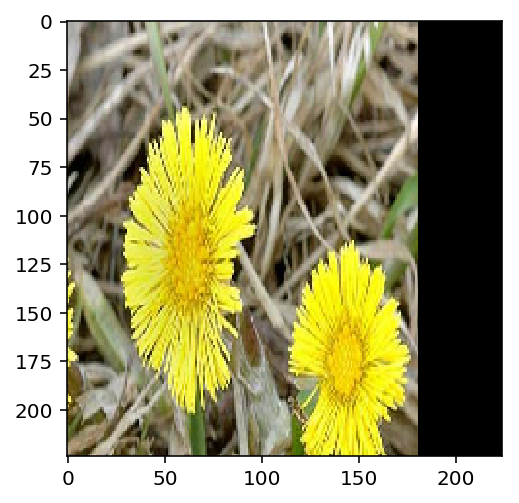

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Find out where image files are relative to workspace

cwd = os.getcwd()
print(cwd)


## not needed currently, but for listing images in folder:
#files = os.listdir(os.curdir + '/flowers/train/1')
#print(files)

#data_dir = 'flowers'
#train_dir = data_dir + '/train'


# grab an image from 'train_dir/1/'

#test_image = (train_dir + '/1/image_06735.jpg')
#test_image = (train_dir + '/1/image_06761.jpg')
test_image = (train_dir + '/12/image_04024.jpg')
# process_image function returns a Numpy array
processed_image = process_image(test_image)

# The project says that the input for the imshow function is a PyTorch Tensor
#

processed_image_t = torch.from_numpy(processed_image)

#print('\n', 'image size and type before inputting to imshow function  ', processed_image_t.size(), type(processed_image_t), '\n')

imshow(processed_image_t)



## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [16]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    
    print('Inside Predict Function')
   
    # From Part 5 Inference and Validation
    model.eval()
    
    
    # process_image returns a numpy array
    
    image = process_image(image_path)
    print('still inside predict function, returned from process_image function')
    print('image type ', type(image))

    #convert image from numpy array to pytorch tensor
    
    image = torch.from_numpy(np.array([image.float()]))
    print('still inside predict function, converted image from numpy array to pytorch tensor')
    print('image type ', type(image))
    
    with torch.no_grad():
        log_probs = model.forward(image)
    
    #exponential function required because of softmax in last layer
    linear_probs = torch.exp(log_probs)
        
    topk_probs, topk_labels = linear_probs.topk(topk)
    
    print(topk_probs, topk_labels)

    
    return none


In [23]:
# Load the model from the checkpoint using the load_checkpoint function
print('device: ', device)
model_densenet121.to(device)


cwd = os.getcwd()
print(cwd)


# for listing files in current working directory:
# need to find where the checkpoint was saved. Or else RETRAIN AND SAVE FOR THE 3rd TIME!!!!!!!!!!!!!!!!!!!!!!!
#files = os.listdir(os.curdir)
#print(files)


model = load_checkpoint('checkpoint.pth')


device:  cpu
/home/workspace/aipnd-project
inside load_checkpoint function
filepath:  checkpoint.pth
past checkpoint = torch.load(filepath)


/opt/conda/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


In [24]:
model
image_path = train_dir + '/1/image_06735.jpg'
# probs, classes = predict(image_path, model)
predict(image_path, model)
#print(probs)
#print(classes)


Inside Predict Function
image open
image height, width:   500 666
still inside predict function, returned from process_image function
image type  <class 'numpy.ndarray'>


AttributeError: 'numpy.ndarray' object has no attribute 'float'

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [19]:
# TODO: Display an image along with the top 5 classes